# Summary: A/B-тест улучшенной рекомендательной модели

### Цель  
Проверить, улучшает ли новая рекомендательная модель (CatBoost + LightGCN + трансформерные признаки) пользовательскую вовлеченность по сравнению с текущей моделью (CatBoost + базовые признаки).

---

### Основная метрика:  
**Hitrate@5** — доля рекомендаций, получивших лайк в течение часа после показа.

| Группа      | Hitrate (по бакетам) |
|-------------|----------------------|
| Control     | 0.7067               |
| Test        | 0.7198               |
| **Δ (приращение)** | **+1.31 п.п.**         |
| **p-value (t-test)** | **9.1e-11**            |

 **Различие статистически значимо.**

---

### Дополнительные метрики:

#### 1. **Доля пользователей, поставивших хотя бы 1 лайк:**
- **Test:** 89.82%
- **Control:** 89.13%
- **Δ:** +0.69 п.п.
- **Z-test:** p = 0.0045 → **значимое различие**

#### 2. **Количество лайков на пользователя:**
- **Test:** 4.00  
- **Control:** 3.91  
- Распределение ненормальное (Shapiro p < 0.001)  
- **Mann–Whitney U-тест:** p = 0.0017 → **значимое различие**

---

### Вывод:

Улучшенная модель рекомендаций **значимо повышает вовлеченность пользователей**:
- Hitrate вырос на **1.31 п.п.**
- **Больше пользователей** взаимодействуют с контентом
- **Общее число лайков на пользователя** также увеличилось

**Рекомендация:** запуск в продакшн и мониторинг устойчивости эффекта.


## Введение и гипотеза

**Цель**  
Проверить, приводит ли добавление новых признаков (features) из модели LightGCN и трансформера к улучшению качества рекомендательной системы по сравнению с текущей моделью на CatBoost с ручными фичами.

**Контрольная модель**  
Модель: CatBoost
Фичи: ручные признаки пользователей и постов
ROC-AUC: 0.77
HitRate@5: 0.706
STD (HitRate): 3.13

**Тестовая модель**   
Модель: CatBoost
Фичи: ручные + LightGCN эмбеддинги + трансформерные признаки
ROC-AUC: 0.812
HitRate@5: 0.715

**Гипотеза**  
Основная гипотеза:

Добавление новых фичей в модель рекомендаций приведёт к росту доли успешных рекомендаций на 1,7%, т.е. увеличение HitRate@5 с 0.706 до 0.718.

**Метрики**  
Основная метрика:
HitRate@5 – доля показов, в которых пользователь поставил лайк хотя бы одному из рекомендованных 5 постов.

Дополнительные метрики:
Доля пользователей, поставивших хотя бы один лайк

Среднее количество лайков на пользователя

**Ожидаемые бизнес-эффекты**  
Рост вовлеченности пользователей – больше взаимодействий с контентом (лайков), значит, пользователи проводят больше времени в продукте.

Повышение удовлетворённости от рекомендаций – более релевантные посты стимулируют лояльность.

### Дизайн эксперимента 
**Рандомизация**  
Пользователи были случайным образом распределены на контрольную и тестовую группы по user_id.
Чтобы исключить смещение и обеспечить стабильность, была использована детерминированная хеш-функция:

```python

import hashlib

def get_exp_group(user_id: int, salt: str = "experiment_1") -> str:
    key = f"{salt}_{user_id}"
    hash_val = hashlib.md5(key.encode()).hexdigest()
    num = int(hash_val[:8], 16) / 0xFFFFFFFF
    return "control" if num < 0.5 else "test"
```
Таким образом:

Пользователь с данным user_id всегда попадает в одну и ту же группу

Размер групп контролируется: по 50% в control и test


**Проверка SRM (Sample Ratio Mismatch)**  
Перед началом анализа провели SRM-тест — проверку, что количество пользователей в контрольной и тестовой группах соответствует ожидаемым пропорциям (50/50).
Для этого использовали χ²-критерий (хи-квадрат) на количество уникальных пользователей 


**Тест и мощность**

α (уровень значимости) = 0.05

MDE (минимально детектируемый эффект) = 0.01 

Baseline метрика (HitRate@5) = 0.706

Тестовая метрика (ожидаемая) = 0.718

Период: 2 недели

Пользователей в каждой группе = 30 000

Тест: бакетный t-test (есть зависимые показы одним и тем же пользователям)

Бакеты: 100 (т.е. анализ будет на агрегированных бакетах, не на уровне пользователей)  
→ 30 000 / 100 = 300 пользователей на бакет в среднем

Поскольку мы используем бакетный t-test, то рассчитываем мощность по разности средних двух выборок:  
Каждая точка — это hitrate в бакете (средняя доля лайков на бакет)  
Всего 100 точек на группу  

**Мощность теста: 0.77**


In [34]:
# расчет мощности

from statsmodels.stats.power import TTestIndPower

effect_size = (0.718 - 0.706) / 0.0313  
alpha = 0.05
nobs = 100 

power_analysis = TTestIndPower()
power = power_analysis.power(effect_size=effect_size, nobs1=nobs, alpha=alpha, ratio=1.0)
print(f"Power: {power:.3f}")


Power: 0.770


## Проверка качества дизайна эксперимента (AA-тест)
Перед запуском A/B-теста мы провели AA-тест на синтетических данных

Проверяем:

Корректность рандомизации (группы не отличаются между собой),

Уровень ложноположительных результатов (α) — должен быть близок к заявленному значению (0.05),

Мощность теста (1 − β) — насколько чувствителен эксперимент к ожидаемому приросту метрики (в нашем случае 0,882 при +1.4 п.п. по HitRate@5).

**Резюме раздела**:
- AA-тест — ложноположительный уровень (alpha): 0.050
- Мощность теста при MDE=0.014: 0.891

In [35]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

N_USERS = 30_000          # Пользователей в каждой группе
N_BUCKETS = 100           # Бакеты
MDE = 0.012              # Минимально детектируемый эффект (1.4 п.п.)
BASE_HITRATE = 0.706      # Базовый HitRate@5
N_EXPERIMENTS = 10000      # Кол-во симуляций AA-теста
ALPHA = 0.05              # Уровень значимости

def simulate_group(hitrate, n_users=N_USERS, n_buckets=N_BUCKETS):
    impressions_per_bucket = n_users // n_buckets
    data = []
    for bucket in range(n_buckets):
        hits = np.random.binomial(1, hitrate, size=impressions_per_bucket)
        data.append({
            'bucket': bucket,
            'hitrate': hits.mean(),
            'impressions': impressions_per_bucket
        })
    return pd.DataFrame(data)


p_values = []

for _ in range(N_EXPERIMENTS):
    control = simulate_group(BASE_HITRATE)
    test = simulate_group(BASE_HITRATE) 
    stat, p = ttest_ind(control['hitrate'], test['hitrate'])
    p_values.append(p)

p_values = np.array(p_values)
alpha_error = (p_values < ALPHA).mean()
print(f"AA-тест — ложноположительный уровень (alpha): {alpha_error:.3f}")


AA-тест — ложноположительный уровень (alpha): 0.050


In [ ]:
p_values_mde = []

for _ in range(N_EXPERIMENTS):
    control = simulate_group(BASE_HITRATE)
    test = simulate_group(BASE_HITRATE + MDE) 
    stat, p = ttest_ind(control['hitrate'], test['hitrate'])
    p_values_mde.append(p)

p_values_mde = np.array(p_values_mde)
power = (p_values_mde < ALPHA).mean()
print(f"Мощность теста при MDE={MDE:.3f}: {power:.3f}")


Мощность теста при MDE=0.012: 0.891


## Анализ результатов теста

### Проверка корректности рандомизации (SRM-check)
1. Удаление пользователей, попавших в обе группы
Перед анализом необходимо убедиться, что каждый пользователь попал только в одну экспериментальную группу. Иначе результаты теста могут быть искажены.
2. Проверка SRM (Sample Ratio Mismatch)

**Резюме раздела**:
- Пользователи, попавшие в обе группы, обнаружены (4 пользователя) и исключены.
- Распределение по группам соответствует ожиданиям (SRM не нарушен, p-value: 0.395).
- Тест можно считать корректно рандомизированным.

In [24]:
recommendations = pd.read_csv('views.csv')
print(recommendations.shape, recommendations.head())

(193295, 4)    user_id exp_group             recommendations   timestamp
0   128381   control  [3644 4529 4704 5294 4808]  1654030803
1   146885      test  [1399 1076  797 7015 5942]  1654030811
2    50948      test  [2315 3037 1861 6567 4093]  1654030825
3    37703      test  [2842 1949  162 1588 6794]  1654030826
4    14661      test  [2395 5881 5648 3417  673]  1654030829


In [25]:
likes = pd.read_csv('likes.csv')
print(likes.shape, likes.head())

(230176, 3)    user_id  post_id   timestamp
0   128381     4704  1654030804
1   146885     1399  1654030816
2    50948     2315  1654030828
3    14661      673  1654030831
4    37703     1588  1654030833


In [27]:
# Найдём user_id, которые встречаются в более чем одной группе

multi_group_users = (
    recommendations.groupby('user_id', as_index=False)['exp_group']
    .nunique()
    .query("exp_group > 1")
)

print(multi_group_users)


       user_id  exp_group
10071    25623          2
20633    55788          2
54475   142283          2
57065   148670          2


In [29]:
recommendations = recommendations[~recommendations['user_id'].isin(multi_group_users)]

In [31]:
recommendations.groupby('exp_group').user_id.nunique()

exp_group
control    32354
test       32663
Name: user_id, dtype: int64

In [33]:
# Проверка деления на группы SRM

from scipy.stats import chi2_contingency

observed = recommendations.groupby('exp_group').user_id.nunique().to_list()

total = sum(observed)
expected = [total / 2, total / 2]

# χ² тест
chi2, p_value, _, _ = chi2_contingency([observed, expected])

print("p-value:", p_value)


p-value: 0.3945716916463896


## Анализ дополнительных метрик
**Доля пользователей, поставивших хотя бы один лайк**

share_test = 0.8982    
share_control = 0.8913 

*z-тест для пропорций:*  

Z-stat: 2.844  
P-value: 0.0045  

Вывод: Различие между группами статистически значимо на уровне значимости 0.05. Это означает, что в тестовой группе больше пользователей проявили активность (поставили хотя бы один лайк)

**Количество лайков на одного пользователя**

likes_test = 4  
likes_control = 3.91

Распределения лайков на пользователя в обеих группах оказались асимметричными, с выраженным правым хвостом.
Даже после логарифмического преобразования (log(1 + x)) данные не соответствуют нормальному распределению по Shapiro–Wilk тесту (p-value < 0.05):

Shapiro test (log likes):
Control group: p ≈ 0.0000
Test group:    p ≈ 0.0000


*Mann–Whitney U-тест:*

stat: 429294691   
P-value: 0.0017

Вывод: Различие статистически значимо на уровне значимости 0.05, что указывает на большее число лайков на пользователя в тестовой группе.

In [31]:
# посчитаем скольк пользователей попали в аб тест, сколько их них лайкали посты

users_ab_count = recommendations.user_id.nunique()

In [32]:
users = recommendations.user_id.unique()
users_likes_count = likes[likes.user_id.isin(users)].user_id.nunique()
users_likes_count/users_ab_count

0.8947595096365343

In [35]:
# Доля пользователей с хотя бы 1 лайком
users_test = recommendations[recommendations['exp_group'] == 'test'].user_id.unique()
users_control = recommendations[recommendations['exp_group'] == 'control'].user_id.unique()

users_likes_test = likes[likes.user_id.isin(users_test)].user_id.nunique()
users_likes_control = likes[likes.user_id.isin(users_control)].user_id.nunique()

share_test = users_likes_test / len(users_test) if len(users_test) > 0 else 0
share_control = users_likes_control / len(users_control) if len(users_control) > 0 else 0

print(f"Test group: {share_test:.4f}, Control group: {share_control:.4f}")


Test group: 0.8982, Control group: 0.8913


In [36]:
# z-тест для пропорций 

from statsmodels.stats.proportion import proportions_ztest

# Число пользователей с хотя бы одним лайком
successes = [users_likes_test, users_likes_control]

# Общее число пользователей в каждой группе
n_obs = [len(users_test), len(users_control)]

# z-тест
z_stat, p_val = proportions_ztest(count=successes, nobs=n_obs)

print(f"Z-stat: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("❗ Различие статистически значимо.")
else:
    print("✅ Нет статистически значимого различия.")


Z-stat: 2.844
P-value: 0.0045
❗ Различие статистически значимо.


In [41]:
# Число лайков на пользователя
likes_per_user_test = likes[likes.user_id.isin(users_test)] \
    .groupby('user_id', as_index=False) \
    .agg(likes_count=('post_id', 'count'))

likes_per_user_control = likes[likes.user_id.isin(users_control)] \
    .groupby('user_id', as_index=False) \
    .agg(likes_count=('post_id', 'count'))


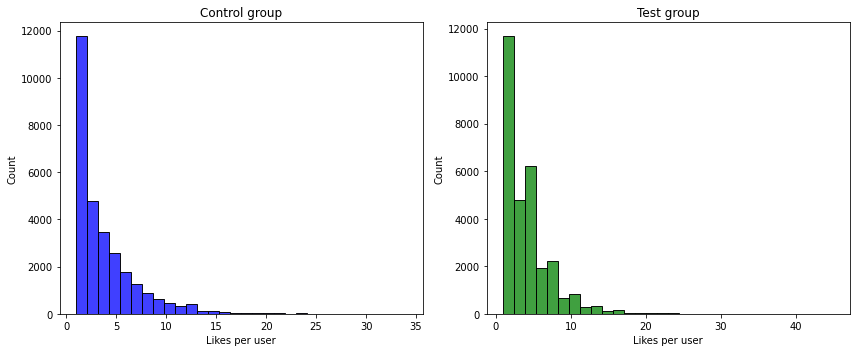

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Control
plt.subplot(1, 2, 1)
sns.histplot(likes_per_user_control['likes_count'], bins=30, kde=False, color='blue')
plt.title('Control group')
plt.xlabel('Likes per user')
plt.ylabel('Count')

# Test
plt.subplot(1, 2, 2)
sns.histplot(likes_per_user_test['likes_count'], bins=30, kde=False, color='green')
plt.title('Test group')
plt.xlabel('Likes per user')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [44]:
likes_per_user_test.likes_count.describe()

count    29337.000000
mean         4.000716
std          3.256923
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         45.000000
Name: likes_count, dtype: float64

In [45]:
likes_per_user_control.likes_count.describe()

count    28838.000000
mean         3.913101
std          3.139696
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         34.000000
Name: likes_count, dtype: float64

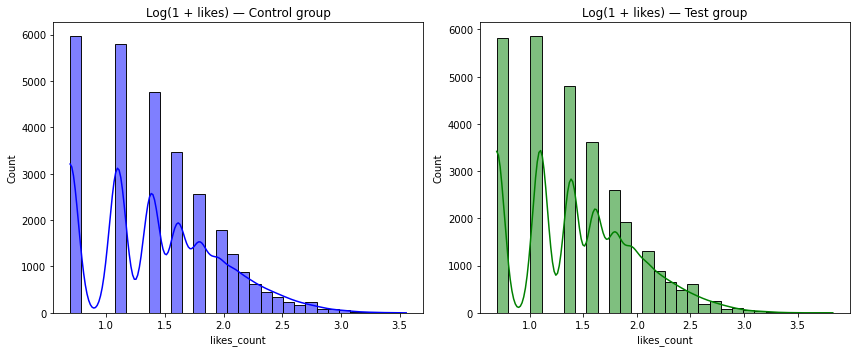

((0.9422839879989624, 2.066564910263024e-40),
 (0.9400901198387146, 5.577588277552069e-41))

In [46]:
#Log-преобразование и t-test

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro


log_test = np.log1p(likes_per_user_test['likes_count'])
log_control = np.log1p(likes_per_user_control['likes_count'])

shapiro_test_stat, shapiro_test_p = shapiro(log_test.sample(5000, random_state=42))
shapiro_control_stat, shapiro_control_p = shapiro(log_control.sample(5000, random_state=42))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(log_control, bins=30, color='blue', kde=True)
plt.title("Log(1 + likes) — Control group")

plt.subplot(1, 2, 2)
sns.histplot(log_test, bins=30, color='green', kde=True)
plt.title("Log(1 + likes) — Test group")

plt.tight_layout()
plt.show()

(shapiro_test_stat, shapiro_test_p), (shapiro_control_stat, shapiro_control_p)


In [43]:
# Mann–Whitney U-тест — сравнение медиан
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(
    likes_per_user_test['likes_count'],
    likes_per_user_control['likes_count'],
    alternative='two-sided'
)

print(f"Mann–Whitney U test: stat={stat:.2f}, p={p:.4f}")


Mann–Whitney U test: stat=429294691.00, p=0.0017


## Расчёт основной метрики: HitRate@5
**Цель:**
Соотнести отображённые пользователю рекомендации с последующими лайками и вычислить долю показов, завершившихся хотя бы одним лайком — HitRate@5.

**Подготовка данных:**
Нумерация показов:
Каждой записи с рекомендациями был присвоен уникальный show_number на основе позиции в датафрейме (recommendations.index).

Разворачивание списка рекомендаций:
Каждая пятёрка постов (из recommendations) была преобразована в отдельные строки, по одной рекомендации на строку — через .explode().

**Соединение с лайками:**
Таблица была соединена с лайками по user_id и post_id, чтобы найти совпадения.

**Фильтрация по времени:**
Считаем лайком только те действия, которые:
- произошли после показа (timestamp_like >= timestamp_view);
- произошли в течение часа после показа (< 1 час).

**Агрегация:**
Для каждого user_id и show_number агрегируем поле is_like и сохраняем максимум (1, если был хотя бы один лайк на 5 рекомендаций).

HitRate@5 (Test)    = 0.7198  
HitRate@5 (Control) = 0.7066



In [37]:
recommendations.dtypes

user_id             int64
exp_group          object
recommendations    object
timestamp           int64
dtype: object

In [38]:
recommendations['show_number'] = recommendations.index
recommendations['recommendations'] = recommendations['recommendations'].apply(
    lambda x: list(map(int, x.strip('[]').split()))
)
recommendations_exploded = recommendations.explode('recommendations').reset_index(drop=True)
recommendations_exploded['timestamp'] = pd.to_datetime(recommendations_exploded['timestamp'], unit='s')
recommendations_exploded = recommendations_exploded.rename(columns={'recommendations': 'post_id', 'timestamp': 'timestamp_view'})

likes = likes.rename(columns={'timestamp': 'timestamp_like'})

In [39]:
views_likes = recommendations_exploded.merge(likes, how='left', on = ['user_id', 'post_id'])

In [40]:
views_likes['timestamp_like'] = pd.to_datetime(views_likes['timestamp_like'], unit='s')
views_likes['time_before_like'] = views_likes['timestamp_like'] - views_likes['timestamp_view']
views_likes.head()

,user_id,exp_group,post_id,timestamp_view,show_number,timestamp_like,time_before_like
0,128381,control,3644,2022-05-31 21:00:03,0,NaT,NaT
1,128381,control,4529,2022-05-31 21:00:03,0,NaT,NaT
2,128381,control,4704,2022-05-31 21:00:03,0,2022-05-31 21:00:04,0 days 00:00:01
3,128381,control,5294,2022-05-31 21:00:03,0,2022-05-31 21:00:38,0 days 00:00:35
4,128381,control,4808,2022-05-31 21:00:03,0,NaT,NaT


In [41]:
views_likes['is_like'] = (
    (views_likes['time_before_like'] >= pd.Timedelta(0)) &
    (views_likes['time_before_like'] < pd.Timedelta(hours=1))
).astype(int)
views_likes.head()

,user_id,exp_group,post_id,timestamp_view,show_number,timestamp_like,time_before_like,is_like
0,128381,control,3644,2022-05-31 21:00:03,0,NaT,NaT,0
1,128381,control,4529,2022-05-31 21:00:03,0,NaT,NaT,0
2,128381,control,4704,2022-05-31 21:00:03,0,2022-05-31 21:00:04,0 days 00:00:01,1
3,128381,control,5294,2022-05-31 21:00:03,0,2022-05-31 21:00:38,0 days 00:00:35,1
4,128381,control,4808,2022-05-31 21:00:03,0,NaT,NaT,0


In [42]:
exp_likes = views_likes.groupby(
    ['user_id', 'exp_group', 'timestamp_view', 'show_number'], as_index=False
).agg(has_like=('is_like', 'max'))


In [43]:
hitrate_test = exp_likes[exp_likes.exp_group == 'test'].has_like.sum() / exp_likes[exp_likes.exp_group == 'test'].has_like.count()
hitrate_control = exp_likes[exp_likes.exp_group == 'control'].has_like.sum() / exp_likes[exp_likes.exp_group == 'control'].has_like.count()

print(hitrate_test, hitrate_control)

0.7198427520455648 0.7066550457573305


In [44]:
exp_likes.shape == recommendations.shape

True

In [45]:
exp_likes.shape

(193295, 5)

## Бакетный анализ и сравнение hitrate

Мы применили бакетизацию по show_number — уникальному идентификатору показа рекомендаций.   
Каждую группу (control и test) мы разделили на 100 бакетов, а затем рассчитали среднее значение hitrate в каждом бакете.  

Затем был применён t-тест (ttest_ind с equal_var=False) для сравнения средних hitrate по бакетам 
в тестовой и контрольной группе.

**Результаты**  
Средний hitrate по бакетам:

Test: 0.7198

Control: 0.7067

Разница: +1.31 п.п. в пользу тестовой группы

T-статистика: 6.8532

P-значение: 9.1e-11

**Вывод**  
Результаты t-теста показывают, что разница между группами статистически значима (p-value ≪ 0.05). Это подтверждает, что добавление новых признаков (фичей из трансформера и LightGCN) в рекомендательную модель привело к улучшению качества рекомендаций по основной метрике — hitrate@5.

Разница в +1.31 п.п. сопоставима с ожидаемым приростом по гипотезе (MDE = 1.2 п.п.) 

In [46]:
N_BUCKETS = 100

exp_likes['bucket'] = exp_likes.groupby('exp_group', group_keys=False).apply(
    lambda x: pd.qcut(x['show_number'], q=N_BUCKETS, labels=False)
).reset_index(drop=True)

bucket_stats = exp_likes.groupby(['exp_group', 'bucket'], as_index=False) \
    .agg(
        hitrate=('has_like', 'mean'),
        impressions=('has_like', 'count')
    )

hitrate_test_avg = bucket_stats[bucket_stats.exp_group == 'test']['hitrate'].mean()
hitrate_control_avg = bucket_stats[bucket_stats.exp_group == 'control']['hitrate'].mean()

print(f"Средний hitrate по бакетам:\nTest: {hitrate_test_avg:.4f}\nControl: {hitrate_control_avg:.4f}")


Средний hitrate по бакетам:
Test: 0.7198
Control: 0.7067


In [49]:
from scipy.stats import ttest_ind

test_buckets = bucket_stats[bucket_stats.exp_group == 'test']['hitrate']
control_buckets = bucket_stats[bucket_stats.exp_group == 'control']['hitrate']

t_stat, p_value = ttest_ind(test_buckets, control_buckets, equal_var=False)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.20f}")



T-статистика: 6.8532
P-значение: 0.00000000009121574751
